In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from sklearn.mixture import GaussianMixture
from sklearn.metrics import mutual_info_score
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding


from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from scipy.stats import f_oneway
from scipy.stats import ttest_rel
from tqdm import tqdm

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

section 1:

  check how we access to the file by loacl path (or path to the drive)
  load data, remove the columns: dAge, dHispanic, iYearwrk and iSex, and id column

section 2:

  clustering algorithms: K-means, hierarchical, dbscan 
  determine num of clusters by k-means: check by elbow (x_axis is clusters num, y_axis is the loss of k-means)
  run 3 clusters algo with the num we determined before: calculate silluette and do ANOVA and T-test (for show the best algo)
  Figures: (1) elbow (2) silluette (bar plot) (3) silluette (by special graph) (4) 2-dim visualization of clustring data by the best algo

section 3:

  a. take the best cluster algo from previous section, and check which external feature has max MI with the clustered data 
  b. for each external (4 columns) we will evaluate by MI all clustering methods VS the external columns, 
    by the clusters number the each external feature has.
  Figures: (a) (1) bar plot: comparison between 4 external features (=x_axis), y_axis is the MI. (calculated by the best algo)
              (2) 2-dim visualization of clustering by best algo, show correlation with one external feature by color
          (b) bar plot: x_axis: 4 external features, y_axis is MI, purpose: show the best algo for each external (by the natural num of each external): 
              (do ANOVA, t-test separatly (4 - for each external))  + show results in table?
      



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
####loading Data
all_data = pd.read_csv(open('drive/MyDrive/USCensus1990.data.csv', 'r'))
data = all_data.drop(columns = ['caseid', 'dAge', 'dHispanic', 'iYearwrk', 'iSex'])
N = len(data.index)
external_vars_list = ['dAge', 'dHispanic', 'iYearwrk', 'iSex']
external_variables = all_data[external_vars_list]

In [ ]:
def kmeans(X, n):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    labels = kmeans.labels_
    return labels

def gmm(X, n):
    gmm = GaussianMixture(n_components=n)
    labels = gmm.fit_predict(X)
    return labels

def hierarchical(X, n):
    hc = AgglomerativeClustering(n_clusters=n)
    hc.fit(X)
    labels = hc.labels_
    return labels
    
def dbscan(X, n, eps = 5, prev = -1, step = 0.1, counter= 0):
    dbs = DBSCAN(eps=eps)
    dbs.fit(X)
    labels = list(dbs.labels_)
    max_labels = max(labels)
    if prev != -1 and abs(prev - max_labels) > 1 and (prev - n + 1)*(max_labels - n + 1) < 0:
      step = step/2
    if counter >= 15:
      return None, None, None
    if max(labels) > n - 1:
      print(f'labels : {max(labels) +1 }')
      return dbscan(X, n , eps=eps+step, prev = max(labels), step = step, counter=counter + 1)
    if max(labels) < n - 1:
      print(f'labels : {max(labels) +1 }')
      return dbscan(X, n_clusters, eps= eps-step, prev = max(labels), step = step, counter = counter + 1)
    print(f'correct labels : {max(labels) +1 }')
    dbscan_X = X.copy()
    idxs = []
    for idx, label in enumerate(labels):
        if label != -1:
            idxs.append(idx)
    dbscan_X =  dbscan_X.iloc[idxs]
    labels = [labels[i] for i in idxs]
    return dbscan_X, labels, idxs

In [ ]:
def plot(X, labels, n_clusters, name=None):
    x_values = X[:,0]
    y_values = X[:,1]
    fig, ax = plt.subplots()
    for i in range(n_clusters):
        ix = np.where(labels == i)
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.scatter(x_values[ix], y_values[ix], c = color, label = i, s = 30)
    ax.legend()
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    if name is not None:
      plt.savefig(name)
    plt.show()
    

num_clusters: 3 loss: 243.86505993600056
num_clusters: 4 loss: 154.3528379901919
num_clusters: 5 loss: 129.72959303593208
num_clusters: 6 loss: 119.15573799880437
num_clusters: 7 loss: 109.29680109801309
num_clusters: 8 loss: 102.0921639363368
num_clusters: 9 loss: 97.26320733266556
num_clusters: 10 loss: 94.83109866700997
num_clusters: 11 loss: 91.13991006923187
num_clusters: 12 loss: 87.3892700561627


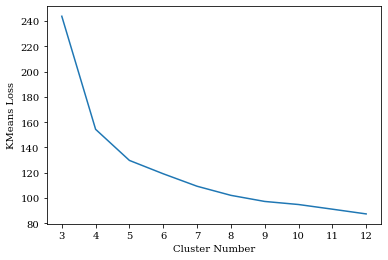

In [ ]:
# Kmeans Elbow Plot
losses = []
clusters = []
for n in range(3, 13):
  Kmeans = KMeans(n_clusters = n)
  Kmeans.fit(data)
  loss = Kmeans.inertia_ / N
  print(f'num_clusters: {n} loss: {loss}')
  losses.append(loss)
  clusters.append(n)
plt.plot(clusters, losses)
plt.xticks(clusters)
plt.xlabel('Cluster Number')
plt.ylabel('KMeans Loss')
plt.savefig('Fig1A_elbow_method.pdf')
plt.show()

Running Clustering Algorithms
Run 1 / 30
correct labels : 5
Avg Silhouette Scores - Kmean: 0.41862324283446367 Hierarchical: 0.4138704314943905 DBSCAN: 0.7785577166129884 GMM: 0.32107054942799523
Run 2 / 30
correct labels : 5
Avg Silhouette Scores - Kmean: 0.41732962340365304 Hierarchical: 0.398121309347073 DBSCAN: 0.7814341524544771 GMM: 0.2185076108803819
Run 3 / 30
correct labels : 5
Avg Silhouette Scores - Kmean: 0.4168301703629971 Hierarchical: 0.39735753566176807 DBSCAN: 0.7828510841797423 GMM: 0.2297578826276288
Run 4 / 30
labels : 3
labels : 3
labels : 4
correct labels : 5
Avg Silhouette Scores - Kmean: 0.41835804008324723 Hierarchical: 0.40142779771395287 DBSCAN: 0.7598703582429447 GMM: 0.22807919610367094
Run 5 / 30
correct labels : 5
Avg Silhouette Scores - Kmean: 0.41863147577217114 Hierarchical: 0.4022541855688125 DBSCAN: 0.7836078783759828 GMM: 0.2504419108032347
Run 6 / 30
labels : 3
correct labels : 5
Avg Silhouette Scores - Kmean: 0.4156786441939662 Hierarchical: 0.411

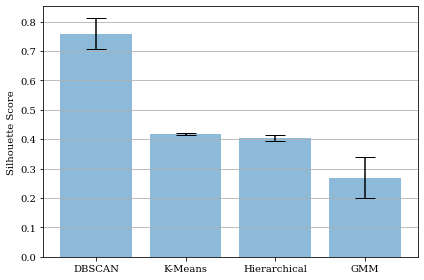

In [ ]:
#### Getting Silhouette scores for KMeans, Hirerchical Clustering, and DBscan
sample_size = 20000 
runs = 30
n_clusters = 5
kmeans_sils = []
hier_sils = []
dbscan_sils = []
gmm_sils = []

print('Running Clustering Algorithms')
for i in range(runs):
  print(f'Run {i+1} / {runs}')
  data_sample = data.sample(sample_size)
  kmeans_labels = kmeans(data_sample, n_clusters)
  kmeans_silhouette = silhouette_score(data_sample, kmeans_labels)
  hierarchical_labels = hierarchical(data_sample, n_clusters)
  hierarchical_silhouette = silhouette_score(data_sample, hierarchical_labels)
  dbscan_data, dbscan_labels, _ = dbscan(data_sample, n_clusters, eps=11.5)
  if dbscan_data is None:
    print('Cant find an epsilion that matches the required number of clusters')
    continue
  dbscan_silhouette = silhouette_score(dbscan_data, dbscan_labels)
  gmm_labels = gmm(data_sample, n_clusters)
  gmm_silhouette = silhouette_score(data_sample, gmm_labels)
  kmeans_sils.append(kmeans_silhouette)
  gmm_sils.append(gmm_silhouette)
  hier_sils.append(hierarchical_silhouette)
  dbscan_sils.append(dbscan_silhouette)
  
  print(f'Avg Silhouette Scores - Kmean: {kmeans_silhouette} Hierarchical: {hierarchical_silhouette} DBSCAN: {dbscan_silhouette} GMM: {gmm_silhouette}')

###performing Anova and paired T-test
print('ANOVA: ', f_oneway(kmeans_sils, hier_sils, dbscan_sils, gmm_sils))
print('T-test (K-means, DBSCAN):', ttest_rel(kmeans_sils, dbscan_sils))

###Plotting bar plot
dbscan_sils = np.array(dbscan_sils)
kmeans_sils = np.array(kmeans_sils)
hier_sils = np.array(hier_sils)
gmm_sils = np.array(gmm_sils)

dbscan_mean = np.mean(dbscan_sils)
kmeans_mean = np.mean(kmeans_sils)
hier_mean = np.mean(hier_sils)
gmm_mean = np.mean(gmm_sils)

dbscan_std = np.std(dbscan_sils)
kmeans_std = np.std(kmeans_sils)
hier_std = np.std(hier_sils)
gmm_std = np.std(gmm_sils)

algos = ['DBSCAN', 'K-Means', 'Hierarchical', 'GMM']
means = [dbscan_mean, kmeans_mean, hier_mean, gmm_mean]
stds = [dbscan_std, kmeans_std, hier_std, gmm_std]
x_pos = np.arange(len(algos))

print(f'Means- Kmeans: {kmeans_mean} Hierarchical: {hier_mean} DBSCAN: {dbscan_mean} GMM: {gmm_mean}')
print(f'Stds - Kmeans: {kmeans_std}, Hierarchical: {hier_std} DBSCAN: {dbscan_std} GMM: {gmm_std}')

fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Silhouette Score')
ax.set_xticks(x_pos)
ax.set_xticklabels(algos)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Fig1B_n=5.pdf')
plt.show()

labels : 4
correct labels : 5
Avg Silhouette Score: 0.4122581368124187


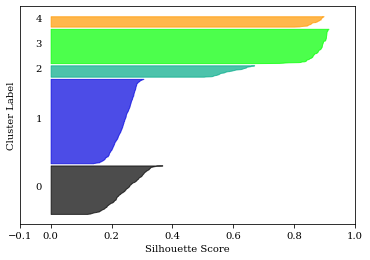

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single nu

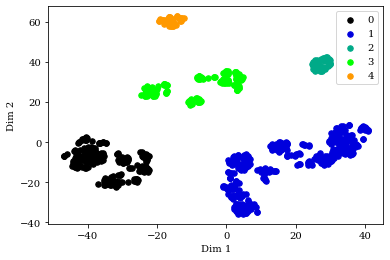

In [ ]:
###Plotting Silhouette of DBSCAN
n_clusters = 5
sample_size = 1000

data_sample = data.sample(sample_size)
dbscan_data, dbscan_labels, idxs = dbscan(data_sample, n_clusters, eps=11.2)

silhouette_avg = silhouette_score(dbscan_data, dbscan_labels)
print(f'Avg Silhouette Score: {silhouette_avg}')
sample_silhouette_values = silhouette_samples(dbscan_data, dbscan_labels)
fig, ax = plt.subplots()
y_lower = 10
for i in range(n_clusters):
  # Aggregate the silhouette scores for samples belonging to
  # cluster i, and sort them
  ith_cluster_silhouette_values = sample_silhouette_values[np.array(dbscan_labels) == i]
  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  color = cm.nipy_spectral(float(i) / n_clusters)
  ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
  ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
  y_lower = y_upper + 10  # 10 for the 0 samples
  ax.set_xlabel("Silhouette Score")
  ax.set_ylabel("Cluster Label")
  ax.set_yticks([])  # Clear the yaxis labels / ticks
  ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.savefig('Silhouette_figure.pdf')
plt.show()



###plotting with TSNE
tsne = TSNE(n_components=2)
new_X = tsne.fit_transform(dbscan_data)
plot(new_X, np.array(dbscan_labels), n_clusters)


In [ ]:
#### Getting mutual information on different external variables on the best clustring acording to the last section

n_clusters = 5
sample_size = 20000
MI = {}
for var in external_vars_list:
  MI[var] = []

for i in range(30):
  data_sample = data.sample(sample_size)
  dbscan_data, dbscan_labels, idxs = dbscan(data_sample, n_clusters, eps=11.2)
  if dbscan_data is None:
    continue
  external_sample = external_variables.iloc[dbscan_data.index]
  for var in external_vars_list:
    mutual_info = mutual_info_score(external_sample[var].to_numpy(), dbscan_labels)
    MI[var].append(mutual_info)
    print(f'External Variable {var} Mutual Information {mutual_info}')


###performing Anova and paired T-test
print('ANOVA: ', f_oneway(MI['dAge'], MI['dHispanic'], MI['iYearwrk'], MI['iSex']))
print('T-test (dAge, iYearwrk):', ttest_rel(MI['dAge'], MI['iYearwrk']))


means = []
stds = []
for var in external_vars_list:
  means.append(np.mean(MI[var]))
  stds.append(np.std(MI[var]))

x_pos = np.arange(len(external_vars_list))

fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('MI')
ax.set_xticks(x_pos)
ax.set_xticklabels(external_vars_list)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('MI_per_external.pdf')
plt.show()

KeyboardInterrupt: ignored

In [ ]:
### Getting MI for each clustring algorithm 


## Num of clusters per external variable
num_clusters_var = {}
for var in external_vars_list:
  num_clusters_var[var] = external_variables[var].max() + 1




{'dAge': 8, 'dHispanic': 10, 'iYearwrk': 8, 'iSex': 2}


External Variable dAge
Run 1/30
labels : 4
labels : 5
labels : 5
labels : 5
labels : 6
correct labels : 8
MI- kmeans: 0.5771193315358109 hier: 0.5215127691401767 dbscan: 0.470708829935465 gmm: 0.5839253029307836
Run 2/30
labels : 5
labels : 5
labels : 6
labels : 6
correct labels : 8
MI- kmeans: 0.5742498896249572 hier: 0.5445532122709581 dbscan: 0.4668092881060053 gmm: 0.5687917784160873
Run 3/30
labels : 6
labels : 6
labels : 7
labels : 9
correct labels : 8
MI- kmeans: 0.571220287940741 hier: 0.5619579294222703 dbscan: 0.47198066591667054 gmm: 0.6028614359130807
Run 4/30
labels : 5
labels : 5
labels : 5
labels : 6
labels : 7
correct labels : 8
MI- kmeans: 0.5766847742587513 hier: 0.5309043080158313 dbscan: 0.47176598073165293 gmm: 0.5821677038306972
Run 5/30
labels : 5
labels : 5
labels : 5
labels : 7
labels : 7
correct labels : 8
MI- kmeans: 0.5700532375252069 hier: 0.5193215160743896 dbscan: 0.46476044650076054 gmm: 0.6290273608633521
Run 6/30
labels : 5
labels : 5
labels : 5
labels

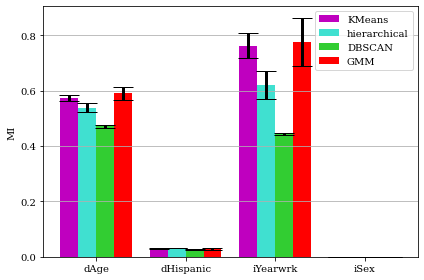

In [ ]:
num_clusters_var = {}
MI = {}
epsilons = {'dAge': 11.5, 'dHispanic': 11, 'iYearwrk': 11.5, 'iSex': 100}
for var in external_vars_list:
  num_clusters_var[var] = external_variables[var].max() + 1
  MI[var] = {'kmeans': [], 'hier': [], 'dbscan': [], 'gmm': []}

for var in external_vars_list:
  print(f'External Variable {var}')
  n_clusters = num_clusters_var[var]
  sample_size = 20000

  for i in range(30):
    print(f'Run {i+1}/30')
    data_sample = data.sample(sample_size)
    dbscan_data, dbscan_labels, _ = dbscan(data_sample, n_clusters, eps=epsilons[var])
    if dbscan_data is None:
      print('Cant find an epsilion that matches the required number of clusters')
      continue
    external_sample_dbscan = external_variables.iloc[dbscan_data.index]
    external_sample = external_variables.iloc[data_sample.index]
    kmeans_labels = kmeans(data_sample, n_clusters)
    kmeans_mi = mutual_info_score(external_sample[var].to_numpy(), kmeans_labels)
    hierarchical_labels = hierarchical(data_sample, n_clusters)
    hierarchical_mi = mutual_info_score(external_sample[var].to_numpy(), hierarchical_labels)

    dbscan_mi = mutual_info_score(external_sample_dbscan[var].to_numpy(), dbscan_labels)
    gmm_labels = gmm(data_sample, n_clusters)
    gmm_mi = mutual_info_score(external_sample[var].to_numpy(), gmm_labels)
    MI[var]['kmeans'].append(kmeans_mi)
    MI[var]['hier'].append(hierarchical_mi)
    MI[var]['dbscan'].append(dbscan_mi)
    MI[var]['gmm'].append(gmm_mi)
    print(f'MI- kmeans: {kmeans_mi} hier: {hierarchical_mi} dbscan: {dbscan_mi} gmm: {gmm_mi}')
  print('ANOVA: ', f_oneway(MI[var]['kmeans'], MI[var]['hier'], MI[var]['dbscan'], MI[var]['gmm']))
  print('T-test (GMM, Kmeans):', ttest_rel(MI[var]['kmeans'], MI[var]['gmm']))

plot_MI_bar(MI)

External Variable dAge
Run 1/30
labels : 5
labels : 5
correct labels : 8
MI- kmeans: 0.5755172644900499 hier: 0.5267941206275976 dbscan: 0.46374779763156737 gmm: 0.5958823983456385
Run 2/30
labels : 5
labels : 5
labels : 6
correct labels : 8
MI- kmeans: 0.5755874505656442 hier: 0.5259617445103371 dbscan: 0.46894544230032 gmm: 0.5956264493130841
Run 3/30
labels : 5
labels : 5
labels : 6
labels : 6
labels : 7
correct labels : 8
MI- kmeans: 0.5744382575928518 hier: 0.5320104828586835 dbscan: 0.47080227864429264 gmm: 0.6052892092269553
Run 4/30
labels : 6
labels : 6
labels : 6
labels : 6
labels : 7
labels : 9
correct labels : 8
MI- kmeans: 0.5425947893366923 hier: 0.527206510332882 dbscan: 0.4709834146435492 gmm: 0.6012979654898454
Run 5/30
labels : 3
labels : 4
labels : 5
labels : 7
labels : 7
labels : 9
labels : 7
labels : 9
labels : 9
labels : 7
labels : 9
labels : 7
labels : 9
labels : 7
labels : 7
Cant find an epsilion that matches the required number of clusters
Run 6/30
labels : 5
l

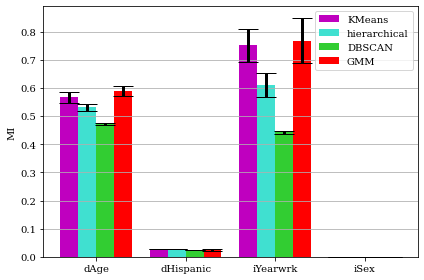

In [ ]:
num_clusters_var = {}
MI = {}
epsilons = {'dAge': 11.5, 'dHispanic': 11, 'iYearwrk': 11.5, 'iSex': 100}
for var in external_vars_list:
  num_clusters_var[var] = external_variables[var].max() + 1
  MI[var] = {'kmeans': [], 'hier': [], 'dbscan': [], 'gmm': []}

for var in external_vars_list:
  print(f'External Variable {var}')
  n_clusters = num_clusters_var[var]
  sample_size = 20000

  for i in range(30):
    print(f'Run {i+1}/30')
    data_sample = data.sample(sample_size)
    dbscan_data, dbscan_labels, _ = dbscan(data_sample, n_clusters, eps=epsilons[var])
    if dbscan_data is None:
      print('Cant find an epsilion that matches the required number of clusters')
      continue
    external_sample_dbscan = external_variables.iloc[dbscan_data.index]
    external_sample = external_variables.iloc[data_sample.index]
    kmeans_labels = kmeans(data_sample, n_clusters)
    kmeans_mi = mutual_info_score(external_sample[var].to_numpy(), kmeans_labels)
    hierarchical_labels = hierarchical(data_sample, n_clusters)
    hierarchical_mi = mutual_info_score(external_sample[var].to_numpy(), hierarchical_labels)

    dbscan_mi = mutual_info_score(external_sample_dbscan[var].to_numpy(), dbscan_labels)
    gmm_labels = gmm(data_sample, n_clusters)
    gmm_mi = mutual_info_score(external_sample[var].to_numpy(), gmm_labels)
    MI[var]['kmeans'].append(kmeans_mi)
    MI[var]['hier'].append(hierarchical_mi)
    MI[var]['dbscan'].append(dbscan_mi)
    MI[var]['gmm'].append(gmm_mi)
    print(f'MI- kmeans: {kmeans_mi} hier: {hierarchical_mi} dbscan: {dbscan_mi} gmm: {gmm_mi}')
  print('ANOVA: ', f_oneway(MI[var]['kmeans'], MI[var]['hier'], MI[var]['dbscan'], MI[var]['gmm']))
  print('T-test (GMM, Kmeans):', ttest_rel(MI[var]['kmeans'], MI[var]['gmm']))

plot_MI_bar(MI)

In [ ]:
def plot_MI_bar(my_dict):
    ticks = my_dict.keys()
    fig, ax = plt.subplots()
    # set width of bar
    barWidth = 0.2

    for ind, (variable_name, value) in enumerate(my_dict.items()):
        kmeans_MI = value['kmeans']
        hier_MI = value['hier']
        dbscan_MI = value['dbscan']
        gmm_MI = value['gmm']

        kmeans_mean = np.mean(kmeans_MI)
        hier_mean = np.mean(hier_MI)
        dbscan_mean = np.mean(dbscan_MI)
        gmm_mean = np.mean(gmm_MI)

        # Calculate the standard deviation
        kmeans_std = np.std(kmeans_MI)
        hier_std = np.std(hier_MI)
        dbscan_std = np.std(dbscan_MI)
        gmm_std = np.std(gmm_MI)


        # Build the plot

        # Set position of bar on X axis
        br1 = np.arange(1)
        br1[0] = ind
        br2 = [x + barWidth for x in br1]
        br3 = [x + barWidth for x in br2]
        br4 = [x + barWidth for x in br3]

        # Make the plot
        kmean = plt.bar(br1, kmeans_mean, width=barWidth, color='m', label='KMeans')
        hier = plt.bar(br2, hier_mean, width=barWidth, color='turquoise', label='hierarchical')
        dbscan = plt.bar(br3, dbscan_mean, width=barWidth, color='limegreen',  label='DBSCAN')
        gmm = plt.bar(br4, gmm_mean, width=barWidth, color='red', label='GMM')

        plt.errorbar(br1, kmeans_mean, yerr=kmeans_std, capsize=10,ecolor='k', elinewidth=3)
        plt.errorbar(br2, hier_mean, yerr=hier_std, capsize=10, ecolor='k',elinewidth=3)
        plt.errorbar(br3, dbscan_mean, yerr=dbscan_std, capsize=10,ecolor='k', elinewidth=3)
        plt.errorbar(br4, gmm_mean, yerr=gmm_std, capsize=10,ecolor='k', elinewidth=3)

    # Adding Xticks
    plt.ylabel('MI')
    plt.grid(axis = 'y')
    plt.xticks([r + 1.5*barWidth for r in range(len(ticks))],
               ticks)

    # ax.set_ylabel('Mutual Information')
    plt.tight_layout()
    # ax.legend()
    # plt.legend(["kmean", "AC", "DBSCAN"])
    ax.legend(handles=[kmean, hier, dbscan, gmm])
    plt.savefig('multi_bar_MI.pdf')
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

pca_silhouette_avg -0.05605688023794078


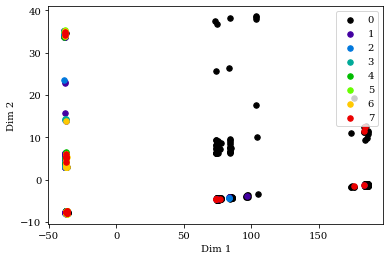

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

mds_silhouette_avg 0.07630471454395876


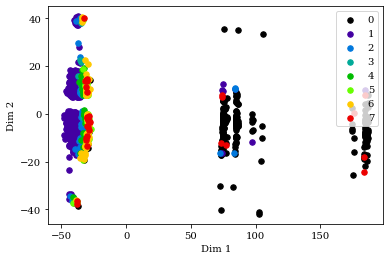

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

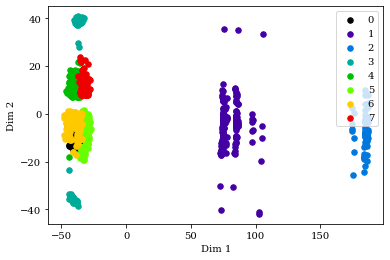

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

isomap_silhouette_avg 0.08820640342956446


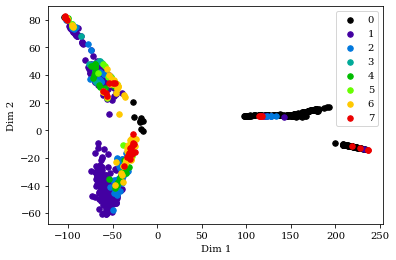

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

lle_silhouette_avg -0.19482422871447003


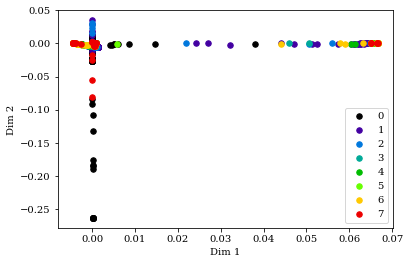

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color

lem_silhouette_avg -0.0706429466905431


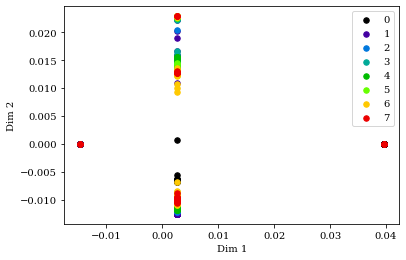

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Pl

lem_silhouette_avg 0.004712753720656551


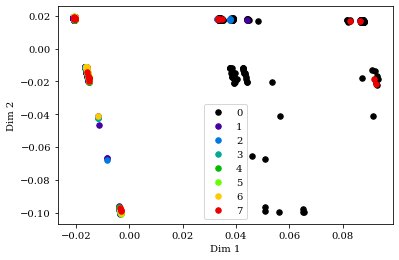

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single nu

tsne_silhouette_avg -0.003263226943090558


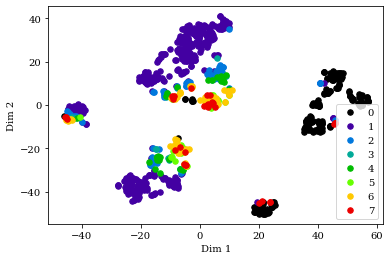

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

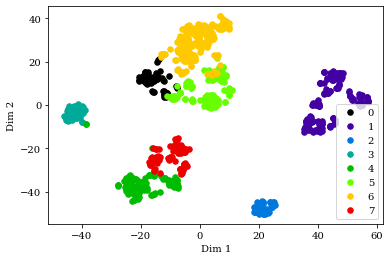

Silhouettes: PCA -0.05605688023794078 MDS 0.07630471454395876 Isomap 0.08820640342956446 LLE -0.19482422871447003 LEM -0.0706429466905431 TSNE -0.003263226943090558


In [ ]:
n_clusters = 8
sample_size = 1000

var = 'iYearwrk'
data_sample = data.sample(sample_size)
#dbscan_data, dbscan_labels, idxs = dbscan(data_sample, n_clusters, eps=11.2)
labels = gmm(data_sample, n_clusters)
external_sample = external_variables.iloc[data_sample.index]

pca = PCA(n_components=2)
pca.fit(data_sample)
pca_X = pca.transform(data_sample)

silhouette_pca = silhouette_score(pca_X, np.array(external_sample[var]))
print(f'pca_silhouette_avg {silhouette_pca}')
plot(pca_X, np.array(external_sample[var]), n_clusters)

mds = MDS(n_components=2)
mds_X = mds.fit_transform(data_sample)

silhouette_mds = silhouette_score(mds_X, np.array(external_sample[var]))
print(f'mds_silhouette_avg {silhouette_mds}')
plot(mds_X, np.array(external_sample[var]), n_clusters, name = f'mds_labels_clusters_{var}.pdf')
plot(mds_X, np.array(labels), n_clusters, name = f'mds_gmm_clusters_{var}.pdf')

isomap = Isomap(n_components=2, n_neighbors=7)
isomap_X = isomap.fit_transform(data_sample)

silhouette_isomap = silhouette_score(isomap_X, np.array(external_sample[var]))
print(f'isomap_silhouette_avg {silhouette_isomap}')
plot(isomap_X, np.array(external_sample[var]), n_clusters)

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=7)
lle_X = lle.fit_transform(data_sample)

silhouette_lle = silhouette_score(lle_X, np.array(external_sample[var]))
print(f'lle_silhouette_avg {silhouette_lle}')
plot(lle_X, np.array(external_sample[var]), n_clusters)

lem = SpectralEmbedding(n_components=2, n_neighbors=8)
lem_X = lem.fit_transform(data_sample)

silhouette_lem = silhouette_score(lem_X, np.array(external_sample[var]))
print(f'lem_silhouette_avg {silhouette_lem}')
plot(lem_X, np.array(external_sample[var]), n_clusters)

ica = FastICA(n_components=2)
ica_X = ica.fit_transform(data_sample)

silhouette_ica = silhouette_score(ica_X, np.array(external_sample[var]))
print(f'lem_silhouette_avg {silhouette_ica}')
plot(ica_X, np.array(external_sample[var]), n_clusters)

tsne = TSNE(n_components=2)
tsne_X = tsne.fit_transform(data_sample)

silhouette_tsne = silhouette_score(tsne_X, np.array(external_sample[var]))
print(f'tsne_silhouette_avg {silhouette_tsne}')
plot(tsne_X, np.array(external_sample[var]), n_clusters)
plot(tsne_X, np.array(labels), n_clusters )

print(f'Silhouettes: PCA {silhouette_pca} MDS {silhouette_mds} Isomap {silhouette_isomap} LLE {silhouette_lle} LEM {silhouette_lem} TSNE {silhouette_tsne}')

In [ ]:
def dim_reduction_comaprison(extr):
  num_clusters_var = {}
  for var in external_vars_list:
    num_clusters_var[var] = external_variables[var].max() + 1
  n_clusters = num_clusters_var[extr]
  sample_size = 1000

  pca_sils = []
  mds_sils = []
  isomap_sils = []
  lle_sils = []
  lem_sils = []
  ica_sils = []
  tsne_sils = []

  for i in range(30):
    print(f'Run {i+1}/30')
    dbscan_data = data.sample(sample_size)
    #dbscan_data, dbscan_labels, idxs = dbscan(data_sample, n_clusters, eps=11.2)
    if dbscan_data is None:
      continue
    external_sample = external_variables.iloc[dbscan_data.index]

    pca = PCA(n_components=2)
    pca.fit(dbscan_data)
    pca_X = pca.transform(dbscan_data)

    silhouette_pca = silhouette_score(pca_X, np.array(external_sample[extr]))
    pca_sils.append(silhouette_pca)

    mds = MDS(n_components=2)
    mds_X = mds.fit_transform(dbscan_data)

    silhouette_mds = silhouette_score(mds_X, np.array(external_sample[extr]))
    mds_sils.append(silhouette_mds)

    isomap = Isomap(n_components=2, n_neighbors=20)
    isomap_X = isomap.fit_transform(dbscan_data)

    silhouette_isomap = silhouette_score(isomap_X, np.array(external_sample[extr]))
    isomap_sils.append(silhouette_isomap)

    lle = LocallyLinearEmbedding(n_components=2, n_neighbors=20)
    lle_X = lle.fit_transform(dbscan_data)

    silhouette_lle = silhouette_score(lle_X, np.array(external_sample[extr]))
    lle_sils.append(silhouette_lle)

    lem = SpectralEmbedding(n_components=2, n_neighbors=8)
    lem_X = lem.fit_transform(dbscan_data)

    silhouette_lem = silhouette_score(lem_X, np.array(external_sample[extr]))
    lem_sils.append(silhouette_lem)

    ica = FastICA(n_components=2)
    ica_X = ica.fit_transform(dbscan_data)

    silhouette_ica = silhouette_score(ica_X, np.array(external_sample[extr]))
    ica_sils.append(silhouette_ica)

    tsne = TSNE(n_components=2)
    tsne_X = tsne.fit_transform(dbscan_data)

    silhouette_tsne = silhouette_score(tsne_X, np.array(external_sample[extr]))
    tsne_sils.append(silhouette_tsne)
    print(f'Silhouettes: PCA {silhouette_pca} MDS {silhouette_mds} Isomap {silhouette_isomap} LLE {silhouette_lle} LEM {silhouette_lem} ICA {silhouette_ica} TSNE {silhouette_tsne}')

  ###performing Anova and paired T-test
  print('ANOVA: ', f_oneway(pca_sils, mds_sils, isomap_sils, lle_sils, lem_sils, tsne_sils))
  print('T-test (MDS, TSNE):', ttest_rel(mds_sils, tsne_sils))

  ###Plotting bar plot
  pca_sils = np.array(pca_sils)
  mds_sils = np.array(mds_sils)
  isomap_sils = np.array(isomap_sils)
  lle_sils = np.array(lle_sils)
  lem_sils = np.array(lem_sils)
  ica_sils = np.array(ica_sils)
  tsne_sils = np.array(tsne_sils)

  pca_mean = np.mean(pca_sils)
  mds_mean = np.mean(mds_sils)
  isomap_mean = np.mean(isomap_sils)
  lle_mean = np.mean(lle_sils)
  lem_mean = np.mean(lem_sils)
  ica_mean = np.mean(ica_sils)
  tsne_mean = np.mean(tsne_sils)

  pca_std = np.std(pca_sils)
  mds_std = np.std(mds_sils)
  isomap_std = np.std(isomap_sils)
  lle_std = np.std(lle_sils)
  lem_std = np.std(lem_sils)
  ica_std = np.std(ica_sils)
  tsne_std = np.std(tsne_sils)

  algos = ['PCA', 'MDS', 'Isomap', 'LLE', 'LEM', 'ICA', 'TSNE']
  means = [pca_mean, mds_mean, isomap_mean, lle_mean, lem_mean, ica_mean, tsne_mean]
  stds = [pca_std, mds_std, isomap_std, lle_std, lem_std, ica_std, tsne_std]
  print(f'Means for {algos} : {means}')
  x_pos = np.arange(len(algos))


  fig, ax = plt.subplots()
  ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
  ax.set_ylabel('Supervised Silhouette Score')
  ax.set_xticks(x_pos)
  ax.set_xticklabels(algos)
  ax.yaxis.grid(True)

  # Save the figure and show
  plt.tight_layout()
  plt.savefig(f'dim_reduction_silhouettes_{extr}.pdf')
  plt.show()

Run 1/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.1128438091010374 MDS -0.0806245877346129 Isomap -0.08742243285218705 LLE -0.07335616209835757 LEM -0.06504154843588075 ICA -0.14356219874283882 TSNE -0.08161137998104095
Run 2/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.11138466792070473 MDS -0.06125463842433727 Isomap -0.08256430630146522 LLE -0.07084268236925706 LEM -0.0904902287249237 ICA -0.12468350186284019 TSNE -0.06281032413244247
Run 3/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.14835447171661229 MDS -0.12367638239863483 Isomap -0.11396377579365849 LLE -0.19381248185847955 LEM -0.24570550365361543 ICA -0.1384571385648635 TSNE -0.08016587793827057
Run 4/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.18966734583101083 MDS -0.15470273000519627 Isomap -0.1459803762488811 LLE -0.17369025513173858 LEM -0.14962397093232743 ICA -0.18125826946721418 TSNE -0.12060098350048065
Run 5/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.10673845216995402 MDS -0.06478950185772851 Isomap -0.07759304489404258 LLE -0.20269257266112384 LEM -0.07925682000085742 ICA -0.1352589768050136 TSNE -0.05329300835728645
Run 6/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.12620876634218814 MDS -0.10342435027125252 Isomap -0.10288459938721672 LLE -0.13221833221651258 LEM -0.0983730264270291 ICA -0.12289471749991723 TSNE -0.08573609590530396
Run 7/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.08889632056913675 MDS -0.04954444833669255 Isomap -0.04616446188381248 LLE -0.2656835099334734 LEM -0.09486336912891964 ICA -0.0942425035864156 TSNE -0.06519661098718643
Run 8/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.1364402474650695 MDS -0.10132466060021002 Isomap -0.11928796269200569 LLE -0.3009752740122895 LEM -0.1802158652790562 ICA -0.1489343497350867 TSNE -0.07036194205284119
Run 9/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.13401619195197043 MDS -0.08336142636909458 Isomap -0.09596093353760997 LLE -0.18426887562660568 LEM -0.06912804506018301 ICA -0.13880396320467114 TSNE -0.09348360449075699
Run 10/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.07770854421303716 MDS -0.054415029356192225 Isomap -0.04429180046104037 LLE -0.10878095589405094 LEM -0.059556190458365 ICA -0.08200398589034567 TSNE -0.05958886817097664
Run 11/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.13274602095846894 MDS -0.08096548035873873 Isomap -0.09334965628707866 LLE -0.11126783062509762 LEM -0.09398142906739236 ICA -0.15207292481135073 TSNE -0.06654234975576401
Run 12/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.18353952216397187 MDS -0.1324135785976482 Isomap -0.12131614434673225 LLE -0.1356331625024644 LEM -0.15672035039022625 ICA -0.18170495866889622 TSNE -0.08011950552463531
Run 13/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.08083829194073075 MDS -0.04151440864762352 Isomap -0.05496912892604722 LLE -0.11273076052170364 LEM -0.07477091942281856 ICA -0.09221018311806911 TSNE -0.056576963514089584
Run 14/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.1665506567280375 MDS -0.11835309190120742 Isomap -0.11157550491324587 LLE -0.257540645782087 LEM -0.19505702262606237 ICA -0.1834222375702975 TSNE -0.0929759219288826
Run 15/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.08627927924810598 MDS -0.06083506786259639 Isomap -0.06493033844486513 LLE -0.23676708065280466 LEM -0.04768017082066403 ICA -0.10483226651106112 TSNE -0.07431855797767639
Run 16/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.12491524276282047 MDS -0.08551208892077186 Isomap -0.11987341326025974 LLE -0.3627254269360858 LEM -0.17436025192092244 ICA -0.1535040295146552 TSNE -0.055572617799043655
Run 17/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.18104717431056522 MDS -0.11061299302375024 Isomap -0.14878941162328696 LLE -0.29270397147314214 LEM -0.19051025507548924 ICA -0.18984076019441226 TSNE -0.1048547700047493
Run 18/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.08641917140830997 MDS -0.08294353624741083 Isomap -0.10111320516979683 LLE -0.14137728835519403 LEM -0.10640607407514402 ICA -0.09603232531833 TSNE -0.08242812007665634
Run 19/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.1791539914860565 MDS -0.11660662441502484 Isomap -0.13163193116656424 LLE -0.09886479002844138 LEM -0.11800623162283 ICA -0.20148735146204422 TSNE -0.09152740240097046
Run 20/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.150376594296566 MDS -0.13394724837836902 Isomap -0.12672740839818633 LLE -0.15417314984228866 LEM -0.1351561128349668 ICA -0.12797006690143375 TSNE -0.13405585289001465
Run 21/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.1328540929659389 MDS -0.11426386876790265 Isomap -0.13704360415183198 LLE -0.11596955243654494 LEM -0.07554683899668245 ICA -0.1360614980458361 TSNE -0.09291808307170868
Run 22/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.19465348430140395 MDS -0.1715142608747855 Isomap -0.16276098873124192 LLE -0.14763034601388314 LEM -0.20836650312330665 ICA -0.16331637214270864 TSNE -0.11189552396535873
Run 23/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.11764888827620903 MDS -0.08819717600596122 Isomap -0.09580454353964062 LLE -0.37208043846484645 LEM -0.055979588775167184 ICA -0.13173660475869992 TSNE -0.08974117785692215
Run 24/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.11375682305432405 MDS -0.0719343136486296 Isomap -0.07924168219378105 LLE -0.24045444234499908 LEM -0.09267855970985549 ICA -0.13680733310837867 TSNE -0.06592855602502823
Run 25/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.20109946985955152 MDS -0.14673706232391742 Isomap -0.16117150429168814 LLE -0.16500004237156235 LEM -0.2141642681539613 ICA -0.18194688533815212 TSNE -0.13373953104019165
Run 26/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.08511905641421123 MDS -0.06891711052185498 Isomap -0.07880393287077021 LLE -0.13923146748176163 LEM -0.2749537787665168 ICA -0.08663509435676466 TSNE -0.07216587662696838
Run 27/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.1629028683577529 MDS -0.12291825252649269 Isomap -0.12020032235208025 LLE -0.20028487747068222 LEM -0.06717100418649388 ICA -0.15130564971844215 TSNE -0.09263931214809418
Run 28/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.1203026831111545 MDS -0.10744082319908056 Isomap -0.1057236116600933 LLE -0.17136419428238533 LEM -0.2047599694698317 ICA -0.13027466837268176 TSNE -0.08387360721826553
Run 29/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.10476882119096577 MDS -0.0935406206364398 Isomap -0.10292322562908071 LLE -0.09694265411013477 LEM -0.08259313456258664 ICA -0.11379643381230824 TSNE -0.06796620041131973
Run 30/30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/l

Silhouettes: PCA -0.09762566162437165 MDS -0.07389420721193352 Isomap -0.051402219585566684 LLE -0.19392030509881045 LEM -0.07512675424058861 ICA -0.10158816559703049 TSNE -0.05307644233107567
ANOVA:  F_onewayResult(statistic=15.623942912432499, pvalue=1.086511332036834e-12)
T-test (MDS, TSNE): Ttest_relResult(statistic=-3.9473466928010628, pvalue=0.0004614698812176214)
Means for ['PCA', 'MDS', 'Isomap', 'LLE', 'LEM', 'ICA', 'TSNE'] : [-0.1311618870580079, -0.09667265231413638, -0.10284884905312526, -0.18176611761989359, -0.12587479286475547, -0.13755484715602534, -0.0825255]


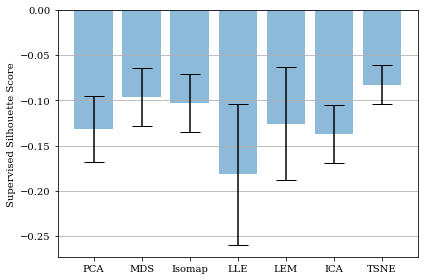

In [ ]:
dim_reduction_comaprison('dAge')